<a href="https://colab.research.google.com/github/ibutin/Innopoilis/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%91%D1%83%D1%82%D0%B8%D0%BD_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение. Постановка целей и задач

Цель этой аттестационной работы - попытаться предсказать поведение акций компании Coca-Cola в следующие 12 мес для принятия возможного решения о среднесрочном инвестировании свободных средств для получения дохода выше депозитного дохода. При этом, необходимо учитывать, что биржевая стоимость акций в среднесрочном и долгосрочном периоде не имеет постоянного цикла изменений и определяется множеством факторов включая стоимость сырьевых товаров, страновые риски, проведение военных действий, выведение на рынок новых товаров. действия конкурентов. правительств и регулирующих органов - т.е биржевая цена, как нам повторяют трейдеры "учитывает ВСЕ". таким образом, проводимый анализ на основании исторических данных цены имеет все-же учебную цель - закрепление пройденного материала по анализу временных рядов

### Импорт Датафрейма, библиотек, написание функций.

В этом блоке мы импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.

In [37]:
!pip install pmdarima

In [38]:
## Здесь импортируем библиотеки и функции 
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
import warnings
warnings.filterwarnings("ignore")

Импортируем данные - из моего репозитория GitHub куда подгрузили датасет заранее

In [39]:
url = 'https://raw.githubusercontent.com/ibutin/Innopoilis/main/COCO%20COLA.csv'

In [40]:
## Здесь импортируем данные.
df = pd.read_csv(url)

### Знакомство с данными.

Этот блок посвящен первоначальному знакомству с данными

Наша задача - посмотреть на данные методами .info(), а также изучить их визуально.


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15096 entries, 0 to 15095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15096 non-null  object 
 1   Open       15096 non-null  float64
 2   High       15096 non-null  float64
 3   Low        15096 non-null  float64
 4   Close      15096 non-null  float64
 5   Adj Close  15096 non-null  float64
 6   Volume     15096 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 825.7+ KB


In [42]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200


In [43]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15096.000000,15096.000000,15096.000000,15096.000000,15096.000000,1.509600e+04
mean,16.056202,16.188428,15.921876,16.060734,11.367487,9.032904e+06
std,16.939301,17.064336,16.811753,16.941712,14.253637,7.935744e+06
min,0.192708,0.193359,0.182292,0.192057,0.037855,7.680000e+04
25%,0.860677,0.869792,0.854167,0.860352,0.242312,2.812800e+06
50%,9.328125,9.398438,9.218750,9.351562,4.642848,7.585200e+06
75%,28.875000,29.167500,28.563125,28.901562,17.251080,1.291275e+07
max,59.810001,60.130001,59.619999,60.130001,58.650002,1.241690e+08


In [44]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Выводы по данным: пропусков нет - в каждой колонке 15096 значений. 7 колонок: 6 показателей биржевой цены и 1 колонка объема торгов.
Формат цены акций - с плавающей точкой, Объем торгов - целое (это ОК, достаточная точность), а вот формат даты Object потребуется преобразовать

In [45]:
## Добавим новую колонку Date_adj в формате  datetime
df['Date_adj'] = pd.to_datetime(df.Date)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Date_adj
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400,1962-01-02
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,1962-01-03
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800,1962-01-04
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,1962-01-05
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,1962-01-08


In [46]:
df.dtypes
## Проверяем формат новой колонки - все ОК

Date                 object
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Date_adj     datetime64[ns]
dtype: object

Теперь проблема - для создания временного ряда требуется проиндексировать dataframe по дате - а это не получилось. т.к. есть пропуски дат (выходные, когда нет торгов, праздники и прочее). Кроме того, нам не требуется чуствительность на уровне дней! мы хотим принять решение о среднесрочном инвестировании в производителя напитков. Т.е. Нам достаточно будет уровня значений в каждом месяце

In [47]:
## Преобразуем Дату Date_adj в колонки Год-Мес-день, потом создадим новую колонку только Год-Мес
df['day'] = df['Date_adj'].dt.day
df['month'] = df['Date_adj'].dt.month
df['year'] = df['Date_adj'].dt.year
df['Mth_date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.head()
## Проверим

,Date,Open,High,Low,Close,Adj Close,Volume,Date_adj,day,month,year,Mth_date
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400,1962-01-02,2,1,1962,1962-01-01
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400,1962-01-03,3,1,1962,1962-01-01
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800,1962-01-04,4,1,1962,1962-01-01
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800,1962-01-05,5,1,1962,1962-01-01
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200,1962-01-08,8,1,1962,1962-01-01


Теперь создадим промежуточный dataframe состоящий из агрегат значений по каждому месяцу. В качестве функции выберем Среднее

In [48]:
df2=df.groupby(by=['Mth_date']).mean()
df2.head()
## Месяцы по которым агрегировали значения в формате datetime в новом dataframe df2 
##стали индексной колонкой. Есть уверенность что пропусков месяцев нет, но проверим

,Open,High,Low,Close,Adj Close,Volume,day,month,year
Mth_date,,,,,,,,,
1962-01-01,0.248432,0.250784,0.245221,0.247692,0.048153,1.337018e+06,16.318182,1.0,1962.0
1962-02-01,0.243695,0.245546,0.241982,0.243318,0.047303,6.952421e+05,14.315789,2.0,1962.0
1962-03-01,0.245531,0.247203,0.244126,0.245517,0.047930,1.939200e+06,16.045455,3.0,1962.0
1962-04-01,0.248340,0.250618,0.245866,0.248047,0.048535,1.023360e+06,15.000000,4.0,1962.0
1962-05-01,0.232762,0.234982,0.227939,0.231564,0.045310,2.234182e+06,15.363636,5.0,1962.0


Уберем лишнюю информацию - оставим только показатели стоимости акций - это будет еще одним промежуточным dataframe df3

In [49]:
df3 = df2.drop(['Adj Close','day','month','year'],1)
df3.head()

,Open,High,Low,Close,Volume
Mth_date,,,,,
1962-01-01,0.248432,0.250784,0.245221,0.247692,1.337018e+06
1962-02-01,0.243695,0.245546,0.241982,0.243318,6.952421e+05
1962-03-01,0.245531,0.247203,0.244126,0.245517,1.939200e+06
1962-04-01,0.248340,0.250618,0.245866,0.248047,1.023360e+06
1962-05-01,0.232762,0.234982,0.227939,0.231564,2.234182e+06


In [50]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 1962-01-01 to 2021-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    720 non-null    float64
 1   High    720 non-null    float64
 2   Low     720 non-null    float64
 3   Close   720 non-null    float64
 4   Volume  720 non-null    float64
dtypes: float64(5)
memory usage: 33.8 KB


### Построим график dataframe df3

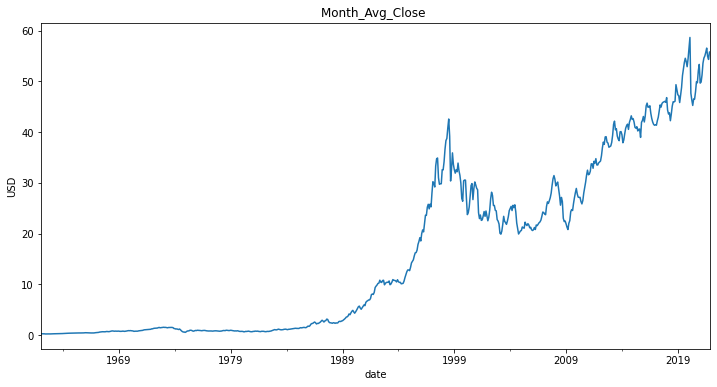

In [51]:
title = 'Month_Avg_Close '
ylabel='USD'
xlabel='date' 

ax = df3['Close'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Очевидно, что этот набор данных "от царя гороха" не требуется в таком объеме. для анализа тренда оставим только данные за последние 10 лет. Это и будет финальный dataframe для последующего прогнозирования

In [52]:
df_final=df3.tail(120)
df_final.head()

,Open,High,Low,Close,Volume
Mth_date,,,,,
2012-01-01,34.203751,34.329000,33.961750,34.120249,1.501158e+07
2012-02-01,34.278250,34.453500,34.115499,34.300500,1.438325e+07
2012-03-01,35.204546,35.439318,35.107954,35.334546,1.864775e+07
2012-04-01,36.841250,37.073250,36.697500,36.897750,1.461850e+07
2012-05-01,38.037500,38.208409,37.834318,38.019092,1.524504e+07


### Построим график dataframe df_final

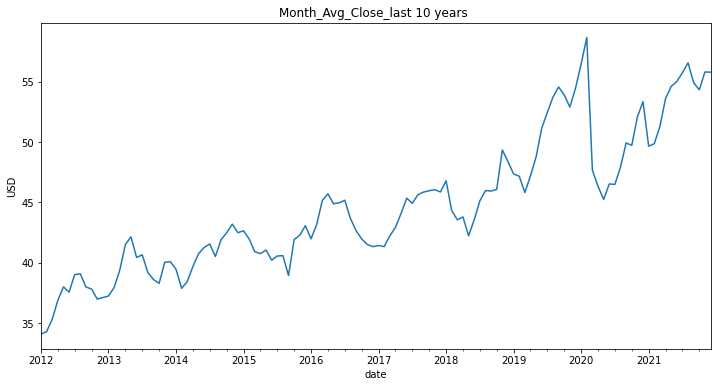

In [53]:
title = 'Month_Avg_Close_last 10 years '
ylabel='USD'
xlabel='date' 

ax = df_final['Close'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### ETS декомпозиция

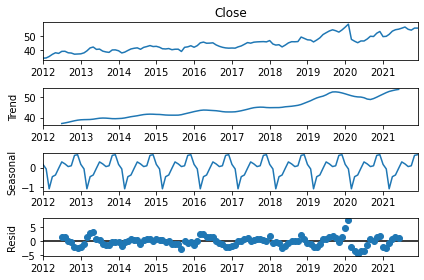

In [54]:
result = seasonal_decompose(df_final['Close'], model='add')
result.plot();

Несмотря на небольшой масштаб по сравнению с общими значениями, существует крошечная годовая сезонность.

Определим сезонный компонент D на стационарность с помощью теста AdFuller

In [55]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df_final):
    dftest = adfuller(df_final)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [56]:
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


Сезонный компонент стационарный, тогда (P,D.Q,M) - принимаем D=0 в Arima!

Определим P для Модели SARIMA

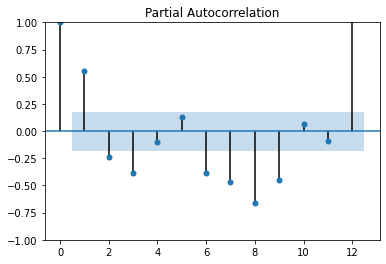

In [57]:
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()

На графике PACF максимальное запаздывание со значением вне доверительных интервалов (светло-синим цветом) равно 2, таким образом, мы можем установить P = 2

Определим Q

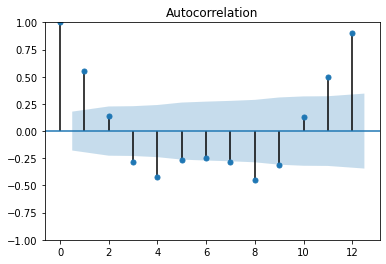

In [58]:
plot_acf(seasonal, lags =12)
plt.show()

Из приведенного выше графика мы отмечаем, что максимальное запаздывание со значением вне доверительных интервалов равно 2, таким образом, Q = 2

Таким образом (P,D,Q,M) = (2,0,2,12) для SARIMA

### Запускаем <tt>pmdarima.auto_arima</tt>

In [59]:
# m=12
auto_arima(df_final['Close'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -213.698
Date:                Thu, 24 Mar 2022   AIC                            439.395
Time:                        07:16:13   BIC                            456.070
Sample:                             0   HQIC                           446.166
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0127      0.011      1.134      0.257      -0.009       0.035
ar.L1          1.6505      0.261      6.335      0.000       1.140       2.161
ar.L2         -0.7361      0.194     -3.800      0.000      -1.116      -0.356
ma.L1         -1.7638      0.277     -6.359      0.000      -2.307      -1.220
ma.L2          0.7715      0.276      2.797      0.005       0.231       1.312
sigma2         2.0984      0.188     11.151      0.000       1.730       2.467
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               809.23
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               6.00   Skew:                            -1.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Параметры (p,d,q) = 2,1,2


### делим на train/test 

In [60]:
len(df_final)

120

In [61]:
# Возьмем 30 на Train и 20 на Тест
train = df_final.iloc[70:100]
test = df_final.iloc[100:]


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2017-11-01 to 2020-04-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    30 non-null     float64
 1   High    30 non-null     float64
 2   Low     30 non-null     float64
 3   Close   30 non-null     float64
 4   Volume  30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2020-05-01 to 2021-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     float64
dtypes: float64(5)
memory usage: 960.0 bytes


### Обучаем SARIMA (2, 1, 2)x(2, 0, 2, 12)

In [64]:
# (2, 1, 2)x(2, 0, 2, 12)
model = SARIMAX(train['Close'], order=(2, 1, 2), seasonal_order=(2, 0, 2, 12) )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   30
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 -65.557
Date:                            Thu, 24 Mar 2022   AIC                            149.115
Time:                                    07:16:16   BIC                            161.420
Sample:                                11-01-2017   HQIC                           152.969
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4017      1.069      0.376      0.707      -1.694       2.497
ar.L2         -0.8842      1.012     -0.874      0.382      -2.867       1.099
ma.L1         -0.3710      0.989     -0.375      0.708      -2.310       1.568
ma.L2          0.3979      1.051      0.379      0.705      -1.661       2.457
ar.S.L12       0.9491    235.422      0.004      0.997    -460.470     462.369
ar.S.L24      -0.8637     83.999     -0.010      0.992    -165.499     163.772
ma.S.L12      -0.5194    318.927     -0.002      0.999    -625.605     624.566
ma.S.L24       0.9078    344.060      0.003      0.998    -673.437     675.252
sigma2         2.9389    905.133      0.003      0.997   -1771.088    1776.966
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                64.95
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               6.03   Skew:                            -2.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# предсказанные значения
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2, 1, 2)x(2, 0, 2, 12) ')

In [66]:
# Сравниваем результаты
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.4}, expected={test['Close'][i]:<11.4}")

predicted=52.89      , expected=45.25      
predicted=57.87      , expected=46.53      
predicted=55.21      , expected=46.5       
predicted=51.04      , expected=47.94      
predicted=52.3       , expected=49.92      
predicted=56.38      , expected=49.72      
predicted=56.11      , expected=52.08      
predicted=53.93      , expected=53.34      
predicted=52.76      , expected=49.65      
predicted=56.79      , expected=49.86      
predicted=54.06      , expected=51.28      
predicted=52.48      , expected=53.59      
predicted=53.85      , expected=54.6       
predicted=55.46      , expected=55.01      
predicted=55.56      , expected=55.73      
predicted=54.17      , expected=56.56      
predicted=53.38      , expected=54.91      
predicted=53.88      , expected=54.32      
predicted=53.17      , expected=55.8       
predicted=54.01      , expected=55.78      


Строим графики

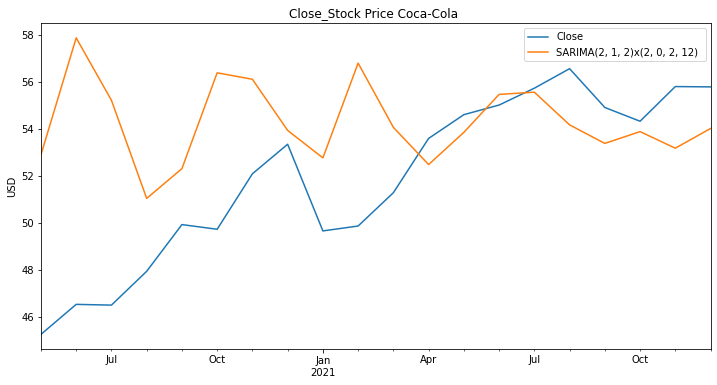

In [67]:
# графики
title = 'Close_Stock Price Coca-Cola '
ylabel='USD'
xlabel=''

ax = test['Close'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Оценка модели

In [68]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Close'], predictions)
print(f'SARIMA(2, 1, 2)x(2, 0, 2, 12) MSE Error: {error:11.5}')

SARIMA(2, 1, 2)x(2, 0, 2, 12) MSE Error:      21.237


In [69]:
from statsmodels.tools.eval_measures import rmse
# rmse = root mse
error = rmse(test['Close'], predictions)
print(f'SARIMA(2, 1, 2)x(2, 0, 2, 12) RMSE Error: {error:11.10}')

SARIMA(2, 1, 2)x(2, 0, 2, 12) RMSE Error: 4.608324679


RMSE около 4 USD, это много для принятия решения, но посмотрим каким будет прогноз. Если положительным (рост акций) - вернемся к вопросу RMSE


### Обучаем модель на полных данных и прогнозируем будущее :)

In [70]:
# (1, 1, 2)x(2, 0, 2, 12)
model = SARIMAX(df_final['Close'],order=(1, 1, 2),seasonal_order=(2, 0, 2, 12))
results = model.fit()

fcast = results.predict(len(df_final),len(df_final)+12,typ='levels').rename('SARIMA(2, 1, 2)x(2, 0, 2, 12) Forecast')


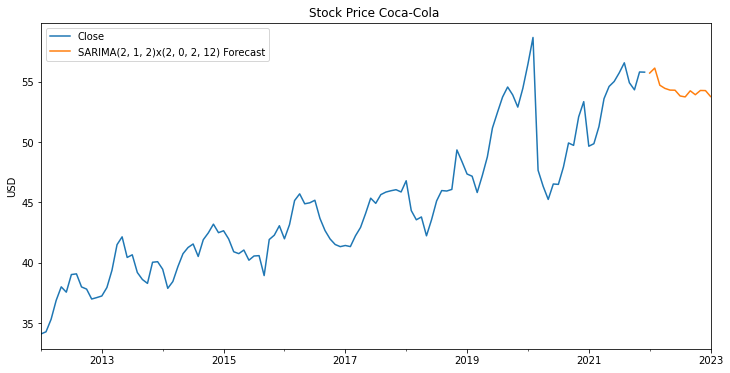

In [71]:
# график
title = 'Stock Price Coca-Cola '
ylabel='USD'
xlabel=''

ax = df_final['Close'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Вывод: в результате исследования построена модель прогнозирования стоимости акций. Результат прогноза - падение стоимости, т.е. среднесрочное инвестирование нецелесообразно.
При этом, необходимо учитывать, что биржевая стоимость акций в среднесрочном и долгосрочном периоде не имеет постоянного цикла изменений и определяется множеством факторов включая стоимость сырьевых товаров, страновые риски, проведение военных действий, выведение на рынок новых товаров. действия конкурентов. правительств и регулирующих органов - т.е биржевая цена, как нам повторяют трейдеры "учитывает ВСЕ". таким образом, проведенный прежде всего достиг учебной цели - закрепление пройденного материала по анализу временных рядов!